In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Load the train and test dataset

train_auto = pd.read_csv('train_auto.csv',sep=",",index_col="INDEX")
test_auto = pd.read_csv('test_auto.csv',sep=",",index_col="INDEX")

train_auto = train_auto.drop(columns=['TARGET_AMT'])
test_auto = test_auto.drop(columns=['TARGET_AMT'])

# Part 1.
The train and the test datasets have been loaded in. It is observed that the column 'TARGET_AMT' is not present in the test dataset. Hence, a decision was made  to drop it.
'TARGET_FLAG' has been identified as the target feature and some exploratory data analysis has been performed below. It can be observed that ~75% of the dataset has a '0' value for the 'TARGET_FLAG'.

In [4]:
#Isolate the target from the remaining features

target = ['TARGET_FLAG']
features = [col for col in train_auto.columns if col not in target]


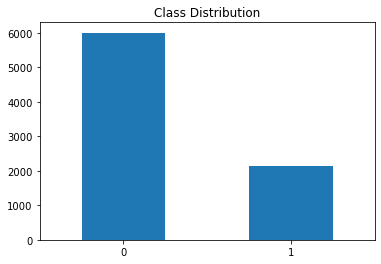

In [5]:
#plot the target distribution

train_auto['TARGET_FLAG'].value_counts().plot(kind='bar', rot=0)
plt.title('Class Distribution')
plt.show()

A function has been created to "clean" the special characters like '$' present in the columns of the dataframe and convert the income and other monetary columns to a numeric value.

In [6]:
#function to clean special characters

def clean_cols(df):
    for col in ['INCOME','OLDCLAIM','BLUEBOOK','HOME_VAL']:
            df[col] = df[col].str.replace('$','').str.replace(',','')
            df[col] = pd.to_numeric(df[col],downcast='float')

Upon examination, the presence of null values in columns was found. About ~29% of the total data in these columns are null. A function has been created below to deal with this. For the numerical columns, the mean of the columns has been used to replace the null values while the most commonly occuring value has been used in the case of categorical columns.

In [7]:
#No. and % of null values

nvc = pd.DataFrame(train_auto.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/train_auto.shape[0],3)*100
print(nvc)

             Total Null Values  Percentage
TARGET_FLAG                  0         0.0
MVR_PTS                      0         0.0
REVOKED                      0         0.0
CLM_FREQ                     0         0.0
OLDCLAIM                     0         0.0
RED_CAR                      0         0.0
CAR_TYPE                     0         0.0
TIF                          0         0.0
BLUEBOOK                     0         0.0
CAR_USE                      0         0.0
TRAVTIME                     0         0.0
URBANICITY                   0         0.0
EDUCATION                    0         0.0
SEX                          0         0.0
MSTATUS                      0         0.0
PARENT1                      0         0.0
HOMEKIDS                     0         0.0
KIDSDRIV                     0         0.0
AGE                          6         0.1
INCOME                     445         5.5
YOJ                        454         5.6
HOME_VAL                   464         5.7
CAR_AGE    

In [8]:
i_num = ['AGE','INCOME','YOJ','HOME_VAL','CAR_AGE']
i_cat = ['JOB']

num_fill_value={}
cat_fill_value={}

def calc_mean(df):
    for col in i_num:
        num_fill_value[col] = np.mean(df[col])
    for col in i_cat:
        cat_fill_value[col] = df[col].value_counts().index[0]

def nan_rep(df):        
    for col in i_num:
        df[col].fillna(num_fill_value[col],inplace=True)
    for col in i_cat: 
        df[col].fillna(cat_fill_value[col],inplace=True)

In [9]:
#Clean the train dataset

clean_cols(train_auto)
calc_mean(train_auto)
nan_rep(train_auto)

A further visualization has been done for the categorical and numerical columns in the dataset below.

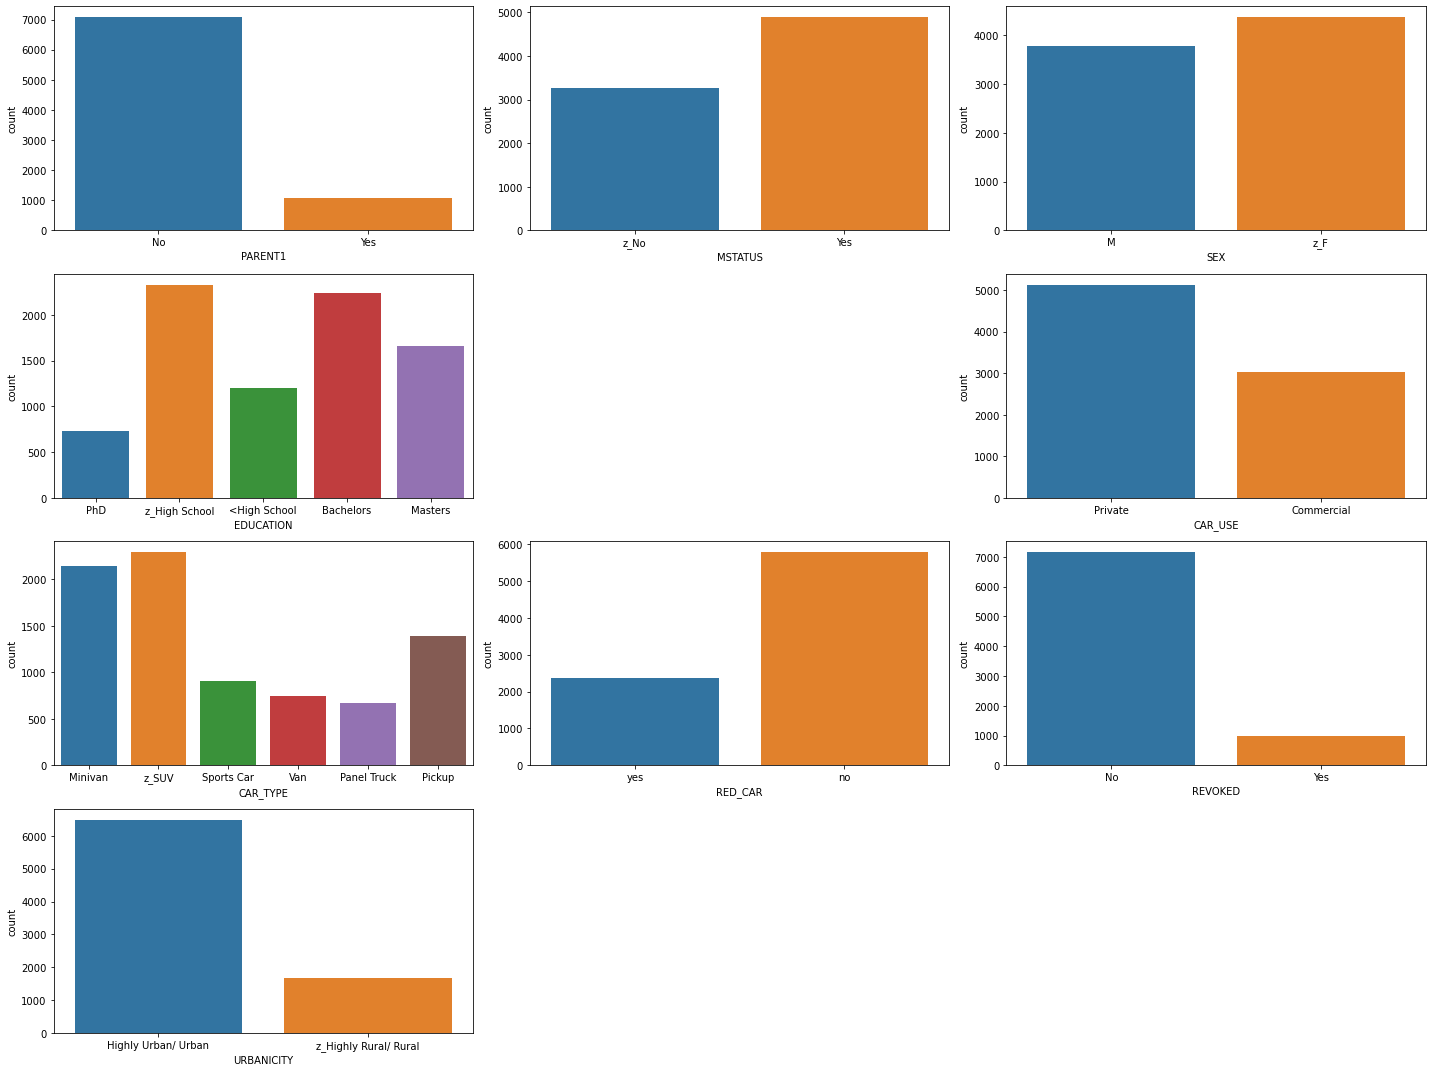

In [13]:
#Plot categorical data

col_cat=train_auto.select_dtypes(include=np.object).columns.tolist()  #Categorical columns

n=3
plt.figure(figsize=[20,15])

for i in range(len(col_cat)):
    if train_auto[col_cat[i]].nunique()<=6:
        plt.subplot(math.ceil(len(col_cat)/n),n,i+1)
        sns.countplot(train_auto[col_cat[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(train_auto[col_cat[i]])
plt.tight_layout()
plt.show()

                                     Features Distribution                                      


C:\Program Files\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


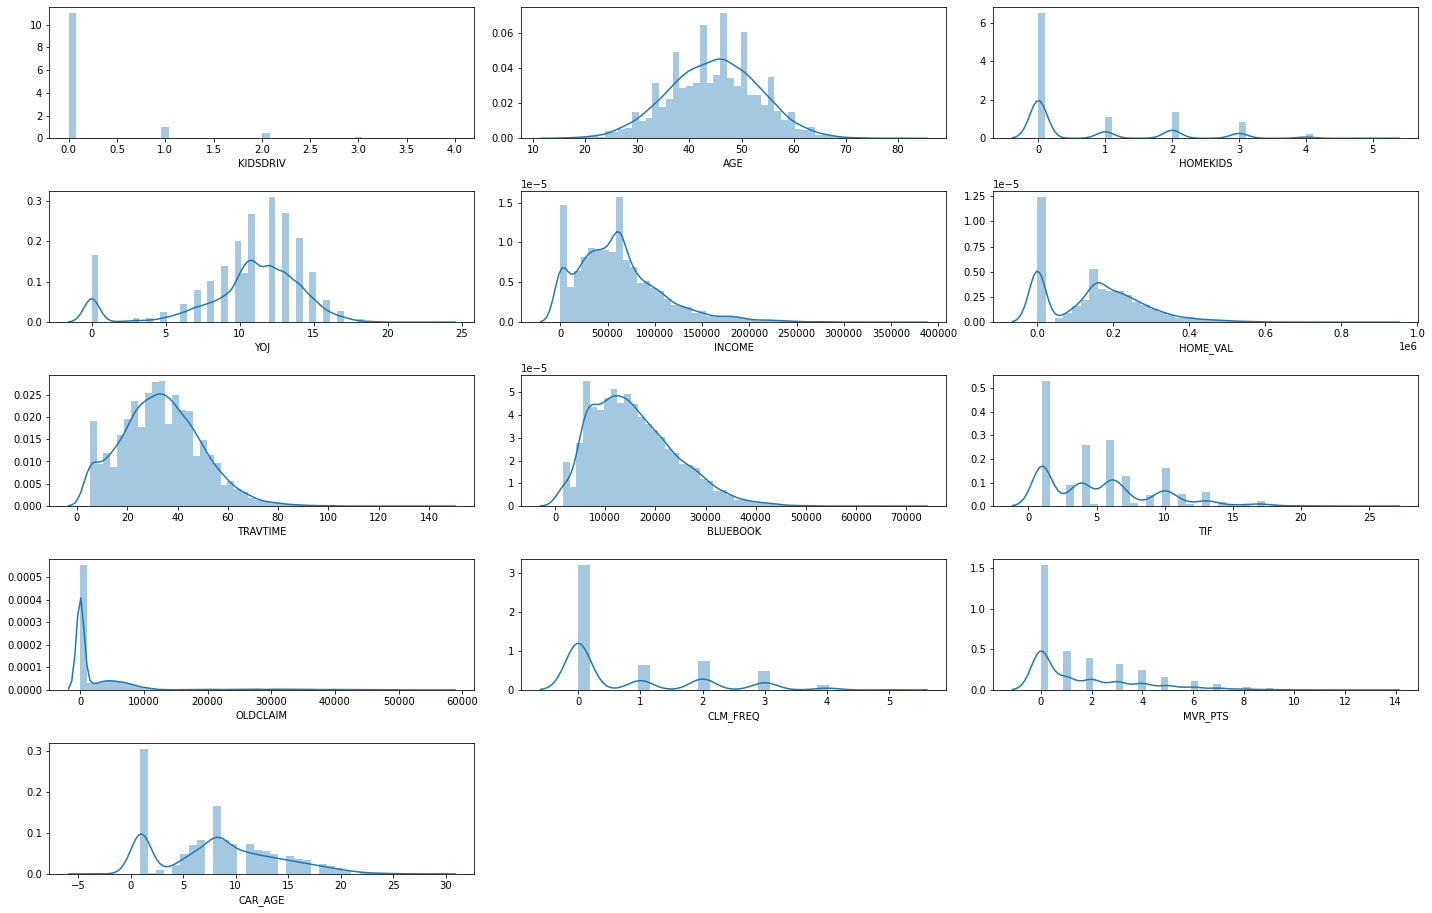

In [15]:
#Plot numerical features

features = [i for i in train_auto.columns.values if i not in target]
print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in col_cat]

plt.figure(figsize=[20,20])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(train_auto[nf[c]])
plt.tight_layout()
plt.show()

A correlation matrix has been plotted for the features in the dataset. High correlation is observed between the target and features like Home value and Income, Car Age and Income etc. However, since there is not much background information about these features, it is hard to establish conclusions on relationships.

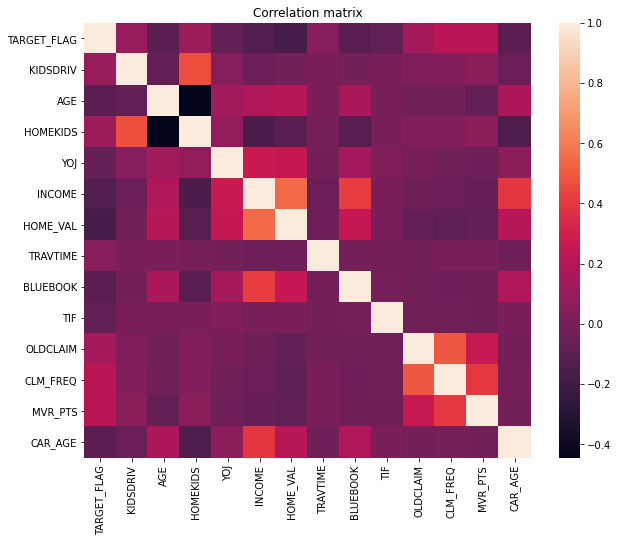

In [17]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
df =  train_auto.drop(columns=[col for col in train_auto.columns if col in col_cat])
corr = df.corr()
sns.heatmap(corr,
            ax=ax
           )
plt.title('Correlation matrix')
plt.show()

# Part 2.
One-hot encoding has been used to transform the categorical features of the dataset. For an initial run, the train dataset has been further divided into train and test datasets to evaluate the performance of RandomForestClassifier, KNeighborsClassifier, SVC, GradientBoostingClassifier and GaussianNB.

The dataset is scaled using the Standard Scaler method and Principal Component Analysis is performed to reduce the dimensionality of the matrix to 80% of the variance.

Cross validation scores (accuracy) are stored and evaluated in order to choose the best model

In [18]:
#One-hot encoding
col_encode=train_auto.select_dtypes(include=np.object).columns.tolist()

train_auto = pd.get_dummies(train_auto, columns = col_encode)

In [19]:
target_columns = ['TARGET_FLAG']
features_train = [col for col in train_auto.columns if col not in target_columns]

In [20]:
#Train and Test split
train, test = train_test_split(train_auto, test_size=0.2)

X,  y = train[features_train],  train[target_columns]
X_test, y_test = test[features_train], test[target_columns]

In [21]:
#Dictionary to declare and the hold the training models

dict_models = {}
dict_score = {'accuracy':{}}    

dict_models[RandomForestClassifier(class_weight='balanced')] = {'n_estimators': range(50,100)}
dict_models[KNeighborsClassifier()] = {'n_neighbors': range(5,15), 'weights': ['uniform', 'distance']}
dict_models[SVC(class_weight='balanced')] = {'C': [0.1, 1, 10]}
dict_models[GradientBoostingClassifier()] = {'learning_rate' : [0.05, 0.06, 0.07, 0.08, 0.09],'max_depth': [i for i in range(2,5)],'min_samples_leaf': [i for i in range(3,10)]}
dict_models[GaussianNB()] = {'var_smoothing': [1e-4, 1e-5, 1e-6]}

In [22]:
# The models are trained using the different models mentioned above and the accuracy is calculated  

for model, grid in dict_models.items():
            pipe = Pipeline([('scaler',StandardScaler()),
                    ('pca',PCA(n_components=0.8)), # Components are enough toexplain over 80% of variance in the data
                    ('gsCV',GridSearchCV(model,param_grid=grid,scoring='accuracy'))
                    ])
            pipe.fit(X,y['TARGET_FLAG'])
            score_ = round(pipe['gsCV'].best_score_,2)
            dict_score['accuracy'][type(model).__name__] = score_

In [23]:
#cross validation scores

dict_score

{'accuracy': {'RandomForestClassifier': 0.77,
  'KNeighborsClassifier': 0.76,
  'SVC': 0.72,
  'GradientBoostingClassifier': 0.78,
  'GaussianNB': 0.76}}

# Part 3.
Gradient Boosting Classifier has been selected as the modeling approach based on the score above. It performs slightly better perhaps, because it is an ensemble of decision trees. This is then applied to the test dataset. The predicted values using the trained model is saved as a .csv

In [24]:
#Cleaning the test dataset

clean_cols(test_auto)
calc_mean(test_auto)
nan_rep(test_auto)

In [25]:
#One-hot encoding

col_encode=test_auto.select_dtypes(include=np.object).columns.tolist()

test_auto = pd.get_dummies(test_auto, columns = col_encode)

In [26]:
target_columns = ['TARGET_FLAG']
features_train = [col for col in train_auto.columns if col not in target_columns]

features_test=[col for col in train_auto.columns if col not in target_columns]

In [27]:
#Train and test data

X1,  y1 = train_auto[features_train],  train_auto[target_columns]
X_test1, y_test1 = test_auto[features_test], test_auto[target_columns]

In [28]:
#Dictionary to hold the best model

dict_models_final = {}
dict_models_final[GradientBoostingClassifier()] = {'learning_rate' : [0.05, 0.06, 0.07, 0.08, 0.09],'max_depth': [i for i in range(2,5)],'min_samples_leaf': [i for i in range(3,10)]}


In [29]:
for model, grid in dict_models_final.items():    
    pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA(n_components=0.8)), # 15 components are enough toexplain over 80% of variance in the data
                ('gsCV',GridSearchCV(model,param_grid=grid,scoring='f1_weighted'))])
    pipe.fit(X,y['TARGET_FLAG'])


In [30]:
#The predicted TARGET_FLAG values are saved as a .csv

y_out = pd.DataFrame({'INDEX':X_test1.index,'TARGET_FLAG':np.zeros(len(X_test1.index))})
y_out['TARGET_FLAG'] = pipe.predict(X_test1)
y_out = y_out.set_index('INDEX')

y_out.to_csv('TARGET_FLAG.csv')